# Load and View Data

Number of data points: 200
k in [0, 199]


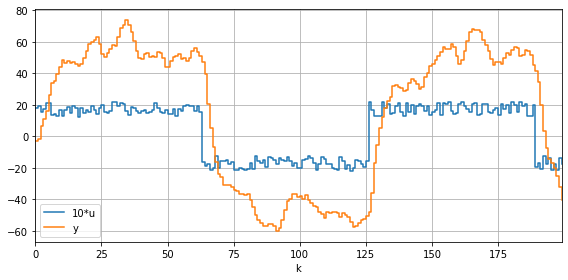

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
df = pd.read_csv(file, header=None, names=['u', 'y'])

print('Number of data points:', len(df))
print(f'k in [{df.index[0]}, {df.index[-1]}]')

k = df.index.values
u = df.u.values
y = df.y.values

plt.figure(figsize=(8,4))
plt.plot(df.index, 10*df.u, label='10*u', drawstyle='steps-post')
plt.plot(df.index, df.y   , label='y'   , drawstyle='steps-post')
plt.xlim(df.index[0], df.index[-1])
plt.xlabel('k')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Modelo Genérico

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

# ARX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\end{gather*}

In [44]:
from pysid import arx

nAmax = 3
nBmax = 3
nKmax = 2

for nA in range(1,nAmax+1):
  for nB in range(1,nBmax+1):
    for nK in range(0, nKmax+1):
      if nB-1 > nA:
        continue

      id = arx(na=nA, nb=nB-1, nk=nK, u=u, y=y)
      A = id.A[0][0]
      B = id.B[0][0]

      # Append zeros so all vectors have same length for pretty print
      A = np.append(A, np.zeros(nAmax - len(A) + 1))
      B = np.append(B, np.zeros(nBmax + nKmax - len(B)))
      
      with np.printoptions(precision=4, suppress=True, sign=' '):
        print(f"nA={nA}, nB={nB}, nK={nK}, A={A}, B={B}")


nA=1, nB=1, nK=0, A=[ 1.     -0.8934  0.      0.    ], B=[ 3.3048  0.      0.      0.      0.    ]
nA=1, nB=1, nK=1, A=[ 1.     -0.8657  0.      0.    ], B=[ 0.      4.0428  0.      0.      0.    ]
nA=1, nB=1, nK=2, A=[ 1.     -0.8426  0.      0.    ], B=[ 0.      0.      4.5798  0.      0.    ]
nA=1, nB=2, nK=0, A=[ 1.     -0.8633  0.      0.    ], B=[ 0.9419  3.2076  0.      0.      0.    ]
nA=1, nB=2, nK=1, A=[ 1.     -0.8339  0.      0.    ], B=[ 0.      2.4809  2.448   0.      0.    ]
nA=1, nB=2, nK=2, A=[ 1.     -0.8427  0.      0.    ], B=[ 0.      0.      4.5823 -0.004   0.    ]
nA=2, nB=1, nK=0, A=[ 1.     -1.4923  0.5566  0.    ], B=[ 1.8404  0.      0.      0.      0.    ]
nA=2, nB=1, nK=1, A=[ 1.     -1.3949  0.4861  0.    ], B=[ 0.      2.6165  0.      0.      0.    ]
nA=2, nB=1, nK=2, A=[ 1.     -1.3817  0.4772  0.    ], B=[ 0.      0.      2.6502  0.      0.    ]
nA=2, nB=2, nK=0, A=[ 1.     -1.3827  0.4758  0.    ], B=[ 0.346   2.3432  0.      0.      0.    ]
nA=2, nB=2

# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

# Output Error

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}